# Python в инженерных расчетах. Лекция 12.
<hr style="border:2px solid gray">

#### План занятия:
1. **Подготовка массива данных для запуска машинного обучения;**
2. **Создание и оценка модели в виде нейронной  (MLPRegressor);**
3. **Поиск наиболее подходящей для имеющихся данных модели с помощью библиотеки LazyRegressor;**
4. **Использоание градиентного бустинга;**
5. **Попытка расширения пространства признаков (учет их взаимодействия)**

In [214]:
# Импортируем нужные библиотеки
import numpy as np
import matplotlib.pyplot as plt

# Импортируем библиотеку для работы с электронными таблицами pandas
import pandas as pd

# Импортируем необходимые нам модули библиотеки машинного обучения sklearn  
from sklearn.model_selection import train_test_split # модуль разбиения на данные для обучения и для проверки
from sklearn.preprocessing import MinMaxScaler # модуль для кодирования матрицы признаков

from sklearn.linear_model import LinearRegression # модуль для обучения методом линейной регрессии
from sklearn.neural_network import MLPRegressor # модуль для обучения с помощью нейронной сети
from xgboost import XGBRegressor # модуль для обучения с помощью градиентного бустинга

from lazypredict.Supervised import LazyRegressor # класс для поиска наилучшей модели для данного набора данных
from sklearn.preprocessing import PolynomialFeatures # класс для расширения пространства признаков

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # методы оценки ошибки модели

from useful_functions import plot_true_vs_predicted # эту функцию мы сделали в лекции 11 и сохранили ее на будущее

## 1. Подготовка массива данных для запуска машинного обучения
<hr style="border:2px solid gray">

In [215]:
# прочитаем датасет, который мы "почистили" на предыдущей лекции
df = pd.read_csv('../data/mech_properties_cleaned.csv') 
# Посмотрим как он выглядит
df.head(5)

,"wt_C, %","wt_Si, %","wt_Mn, %","wt_P, %","wt_S, %","wt_V, %","wt_Nb, %","wt_Ti, %","wt_Al, %","wt_B, %","wt_Cr, %","wt_Ni, %","wt_Cu, %",YieldStress
0,0.11,0.34,0.60,0.03,0.03,0.00,0.00,0.00,0.00,0.00,0.09,0.26,0.26,215.60
1,0.13,0.34,0.60,0.03,0.03,0.00,0.00,0.00,0.00,0.00,0.13,0.26,0.26,225.50
2,0.18,0.34,0.60,0.03,0.03,0.00,0.00,0.00,0.00,0.00,0.21,0.26,0.26,247.50
3,0.23,0.34,0.60,0.03,0.03,0.00,0.00,0.00,0.00,0.00,0.21,0.26,0.26,269.50
4,0.29,0.34,0.76,0.03,0.03,0.00,0.00,0.00,0.00,0.00,0.21,0.26,0.26,302.50


In [216]:
# Разбиваем данные на признаки и целевую функцию
X = df.drop(columns=['YieldStress']) # Удаляем не нужный столбец с пределом текучести
y = df['YieldStress'] # целевая функция - столбец с пределом текучести
# разбиваем данные на данные для обучения и данные для проверки модели (обычно 10% от всего массива)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=42)

In [217]:
# Переходим к кодированному масштабу
scaler = MinMaxScaler(feature_range=(0, 1)) # создаем объект класса MinMaxScaler 
X_train_scaled = scaler.fit_transform(X_train) # нормализуем массив признаков для обучения
X_test_scaled = scaler.transform(X_test) # нормализыем массив признаков для проверки модели

## 2. Создание и оценка модели в виде нейронной сети.
<hr style="border:2px solid gray">

### Нейронная сеть (MLPRegressor)

Многослойный перцептрон (Multi-Layer Perceptron) для задач регрессии — это искусственная нейронная сеть прямого распространения, состоящая из множества взаимосвязанных нейронов, организованных в последовательные слои.

#### Архитектура сети:

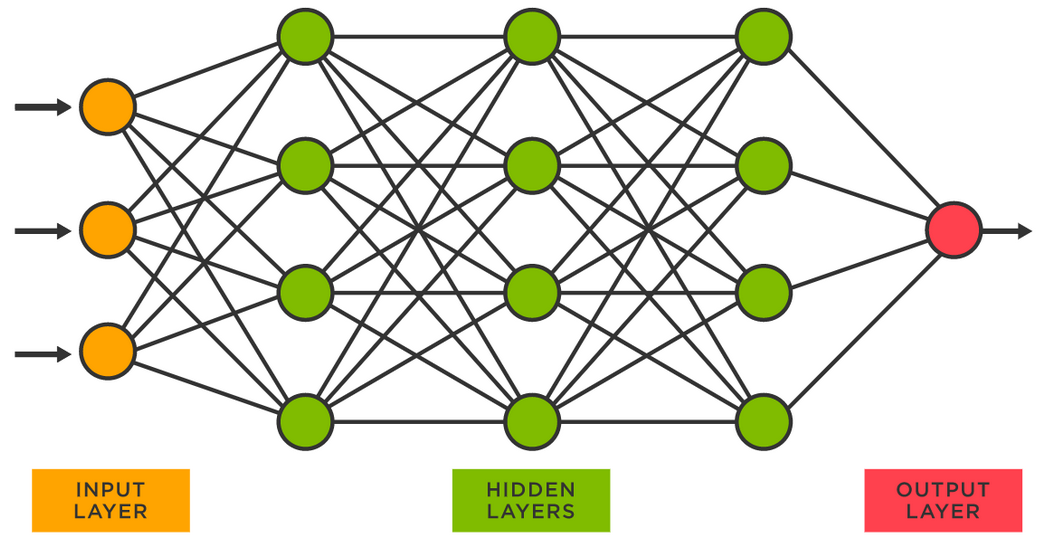

картинка отсюда: https://vitalflux.com/sklearn-neural-network-regression-example-mlpregressor/


#### Ключевые компоненты:

- **Входной слой** — принимает исходные признаки данных (X₁, X₂, X₃, ...)
- **Скрытые слои** — выполняют нелинейные преобразования через функции активации (ReLU, tanh, sigmoid)
- **Выходной слой** — возвращает предсказанное непрерывное значение ŷ
- **Веса и смещения** — параметры, оптимизируемые в процессе обучения
- **Функция потерь** — обычно MSE (среднеквадратичная ошибка) для регрессии

#### Математическое представление:
Для одного нейрона: 
$$z = w_1x_1 + w_2x_2 + \cdots + w_nx_n + b$$
$$a = f(z)$$
где $f$ — функция активации.

Обучение сети происходит методом обратного распространения ошибки (backpropagation) с использованием алгоритмов оптимизации (Adam, SGD).

In [218]:
# Создаём нейросеть
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),   # два скрытых слоя: 64 и 32 нейрона (попробуйте (128, 64, 32))
    activation='relu', # возможные варианты ['relu', 'tanh', 'logistic', 'identity']
    solver='adam', # возможные варианты ['adam', 'sgd', 'lbfgs', ]
    max_iter=10000,
    random_state=42,
    early_stopping=True,           # остановка при отсутствии улучшения
    validation_fraction=0.1        # часть данных для валидации
)

# Обучение
mlp.fit(X_train_scaled, y_train)


print(f'Количество итераций: {len(mlp.validation_scores_)}, последний R² = {mlp.validation_scores_[-1]:2f}')  

Количество итераций: 1554, последний R² = 0.699715


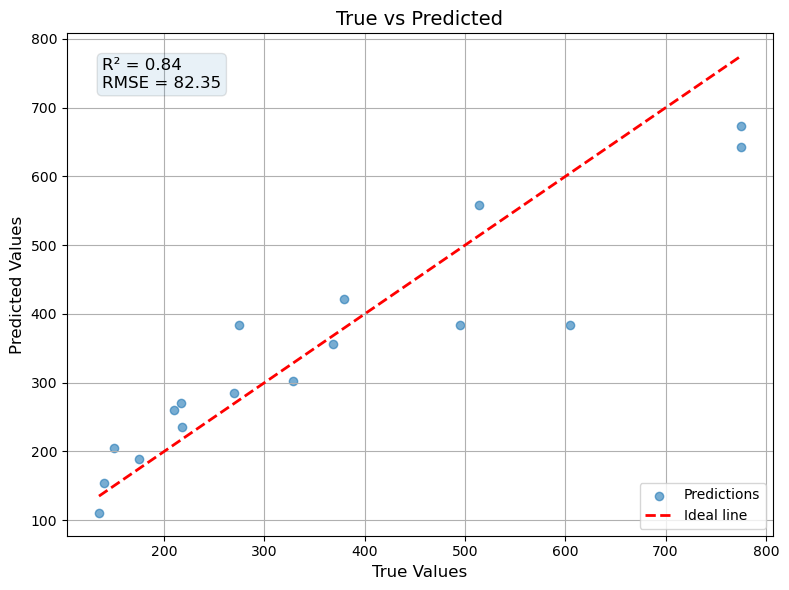

In [219]:
# Расчитываем отклик по данным для проверки
y_pred = mlp.predict(X_test_scaled)
# посмотрим на результат
plot_true_vs_predicted (y_test, y_pred)

## 3. Поиск наиболее подходящей для имеющихся данных модели с помощью библиотеки LazyRegressor
<hr style="border:2px solid gray">

In [220]:
# попробуем найти модель подходящую для нашего набора данных
# Создаём и запускаем LazyRegressor
reg = LazyRegressor(
    verbose=0,            # 0 — тихо, 1 — показывает прогресс
    ignore_warnings=True, # игнорировать предупреждения (например, от моделей, которые не сходятся)
    custom_metric=None    # можно добавить свою метрику, но по умолчанию — R² 
)

# Обучение и предсказание
models, predictions = reg.fit(X_train_scaled, X_test_scaled, y_train, y_test)

# Вывод результатов
print(models)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 123
[LightGBM] [Info] Number of data points in the train set: 144, number of used features: 12
[LightGBM] [Info] Start training from score 396.654167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

## 4. Использование градиентного бустинга
<hr style="border:2px solid gray">

In [221]:
# Создаём модель
model = XGBRegressor(
                    n_estimators=100,
                    max_depth=2,
                    learning_rate=0.1,
                    reg_alpha=0.5,
                    reg_lambda=0.5,
                    subsample=0.8,
                    random_state=42,
                    verbosity=0
                    )
model.fit(X_train_scaled, y_train);

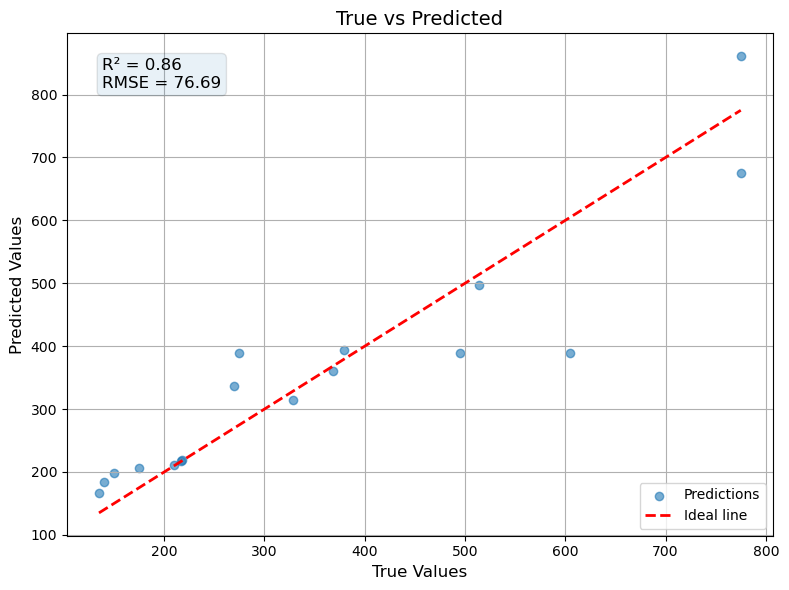

In [222]:
# Расчитываем отклик по данным для проверки
y_pred = model.predict(X_test_scaled)
# посмотрим на результат
plot_true_vs_predicted (y_test, y_pred)

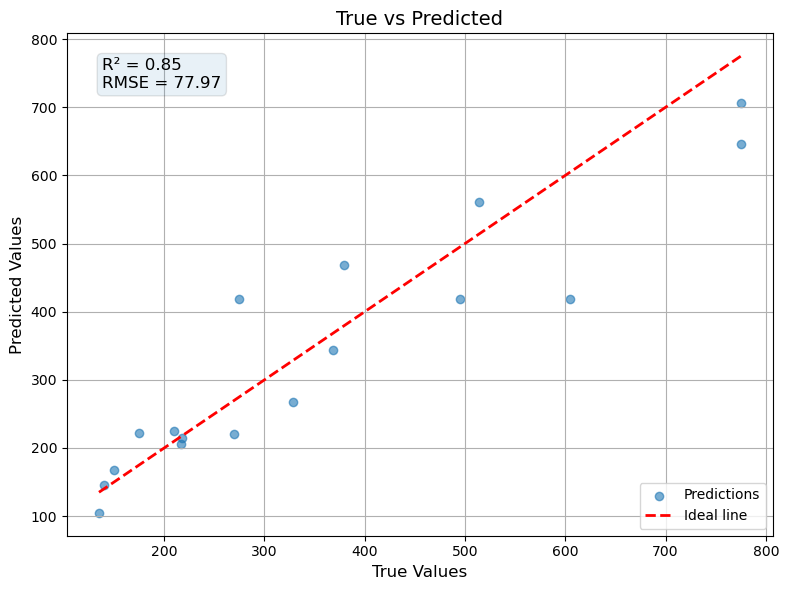

In [223]:
# давайте попробуем рекомендованный BaggingRegressor
from sklearn.ensemble import BaggingRegressor

base_model = LinearRegression()

bagging = BaggingRegressor(estimator=base_model,
                            n_estimators=10,        
                            random_state=42)
bagging.fit(X_train_scaled, y_train);
# Расчитываем отклик по данным для проверки
y_pred = bagging.predict(X_test_scaled)
# посмотрим на результат
plot_true_vs_predicted (y_test, y_pred)


In [224]:
# Уменьшим количество признаков
X = df[['wt_C, %', 'wt_Mn, %', 'wt_Si, %', 'wt_Cr, %', 'wt_B, %']]
# Все остальное без изменений
y = df['YieldStress'] # целевая функция - столбец с пределом текучести
# разбиваем данные на данные для обучения и данные для проверки модели (обычно 10% от всего массива)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=42)
# Переходим к кодированному масштабу
scaler = MinMaxScaler(feature_range=(0, 1)) # создаем объект класса MinMaxScaler 
X_train_scaled = scaler.fit_transform(X_train) # нормализуем массив признаков для обучения
X_test_scaled = scaler.transform(X_test) # нормализыем массив признаков для проверки модели

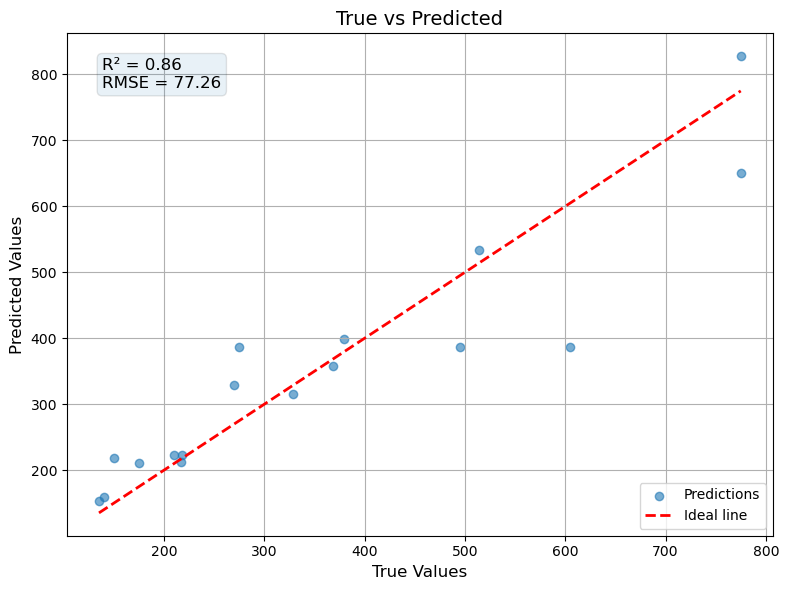

In [225]:
# Создаём модель
model = XGBRegressor(
                    n_estimators=100,
                    max_depth=3,
                    learning_rate=0.1,
                    reg_alpha=0.5,
                    reg_lambda=0.5,
                    subsample=0.8,
                    random_state=42,
                    verbosity=0
                    )
model.fit(X_train_scaled, y_train);
# Расчитываем отклик по данным для проверки
y_pred = model.predict(X_test_scaled)
# посмотрим на результат
plot_true_vs_predicted (y_test, y_pred)

## 5. Попытка расширения пространства признаков (учет их взаимодействия)
<hr style="border:2px solid gray">

In [226]:
# Создаём преобразователь: только взаимодействия (degree=2), без квадратов отдельных признаков
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=True)
# Применяем преобразование
X_poly = poly.fit_transform(X)
print (f'Размер массива X: {X.shape}, размер массива X_poly: {X_poly.shape}')
X_poly[:3, :]


Размер массива X: (161, 5), размер массива X_poly: (161, 56)


array([[1.00000000e+00, 1.09500000e-01, 6.05000000e-01, 3.40000000e-01,
        8.50000000e-02, 0.00000000e+00, 1.19902500e-02, 6.62475000e-02,
        3.72300000e-02, 9.30750000e-03, 0.00000000e+00, 3.66025000e-01,
        2.05700000e-01, 5.14250000e-02, 0.00000000e+00, 1.15600000e-01,
        2.89000000e-02, 0.00000000e+00, 7.22500000e-03, 0.00000000e+00,
        0.00000000e+00, 1.31293237e-03, 7.25410125e-03, 4.07668500e-03,
        1.01917125e-03, 0.00000000e+00, 4.00797375e-02, 2.25241500e-02,
        5.63103750e-03, 0.00000000e+00, 1.26582000e-02, 3.16455000e-03,
        0.00000000e+00, 7.91137500e-04, 0.00000000e+00, 0.00000000e+00,
        2.21445125e-01, 1.24448500e-01, 3.11121250e-02, 0.00000000e+00,
        6.99380000e-02, 1.74845000e-02, 0.00000000e+00, 4.37112500e-03,
        0.00000000e+00, 0.00000000e+00, 3.93040000e-02, 9.82600000e-03,
        0.00000000e+00, 2.45650000e-03, 0.00000000e+00, 0.00000000e+00,
        6.14125000e-04, 0.00000000e+00, 0.00000000e+00, 0.000000

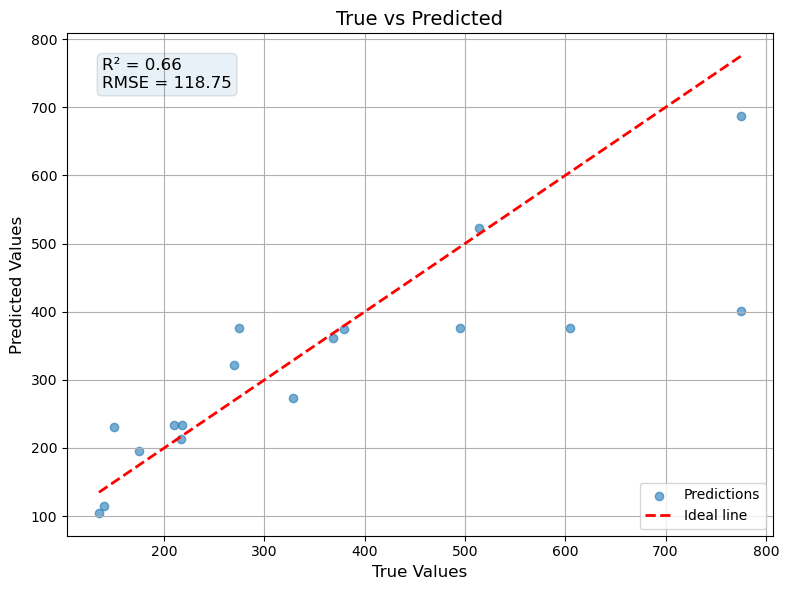

In [227]:
# разбиваем данные на данные для обучения и данные для проверки модели (обычно 10% от всего массива)
X_train, X_test, y_train, y_test = train_test_split(X_poly,y,test_size=0.1,random_state=42)
# Переходим к кодированному масштабу
scaler = MinMaxScaler(feature_range=(0, 1)) # создаем объект класса MinMaxScaler 
X_train_scaled = scaler.fit_transform(X_train) # нормализуем массив признаков для обучения
X_test_scaled = scaler.transform(X_test) # нормализыем массив признаков для проверки модели


# Обучаем линейную регрессию
model = LinearRegression();
model.fit(X_train_scaled, y_train);
# Расчитываем отклик по данным для проверки
y_pred = model.predict(X_test_scaled)
# посмотрим на результат
plot_true_vs_predicted (y_test, y_pred)